# Plot fig. 7.4

In [14]:
import numpy as np
import matplotlib.pyplot as pl
import matplotlib.gridspec as gridspec
import pandas as pd
from matplotlib import rc
from netCDF4 import Dataset
import scipy.stats as st
import warnings
from fair.forcing.ghg import meinshausen, etminan

from ar6.constants import NINETY_TO_ONESIGMA

In [2]:
pl.rcParams['figure.figsize'] = (18/2.54, 9/2.54)
pl.rcParams['font.size'] = 11
pl.rcParams['font.family'] = 'Arial'
pl.rcParams['ytick.direction'] = 'out'
pl.rcParams['ytick.minor.visible'] = True
pl.rcParams['ytick.major.right'] = True
pl.rcParams['ytick.right'] = True
pl.rcParams['xtick.bottom'] = False
pl.rcParams['axes.spines.top'] = False
pl.rcParams['axes.spines.bottom'] = False
pl.rcParams['xtick.labelbottom'] = False
#pl.rcParams['ytick.major.size'] = 0
#pl.rcParams['xtick.top'] = True

In [3]:
expt_names = {
    '10xBC': 'Black\ncarbon',
    '3xCH4': 'Methane',
    '2xCO2': 'Carbon\ndioxide',
    'Solar': 'Solar',
    '5xSO4': 'Sulphate',
    '9xCFC12': 'CFC-12',
    '8xCFC11': 'CFC-11',
    '3xN2O': 'Nitrous\noxide',
    'Volcanic': 'Volcanic'
}

# 10 models, 4 kernels, 8 experiments and 7 adjustments
# do adjust[model, kernel, exp]
n_mod = 10; n_ker = 6; n_exp=9

flux = {}
flux_u90 = {}
valid_count = {}

## Smith et al. 2018

Data is provided in a number of netCDF files from Ryan Kramer

In [4]:
indirs = ['../data_input/Smith_et_al_GRL_2018/pdrmip_kernel_ryan_kramer/', 
          '../data_input/Smith_et_al_GRL_2018/pdrmip_kernel_ryan_kramer/', 
          '../data_input/Smith_et_al_GRL_2018/pdrmip_kernel_ryan_kramer/', 
          '../data_input/Smith_et_al_GRL_2018/pdrmip_kernel_ryan_kramer/', 
          '../data_input/Smith_et_al_GRL_2018/pdrmip_kernel_ryan_kramer/', 
          '../data_input/Smith_et_al_GRL_2018/pdrmip_kernel_ECMWF-Oslo_gunnar_myhre/']
models = ['CanESM2', 'ECHAM-HAM', 'GISS-E2-R', 'HadGEM2', 'HadGEM3', 'IPSL-CM5A', 'MIROC-SPRINTARS', 'MPI-ESM', 'NCAR-CESM1-CAM4', 'NCAR-CESM1-CAM5', 'NorESM1']
kernels = ['HadGEM2', 'GFDL', 'BMRC', 'CCSM4', 'CESM', 'Oslo']
vars = ['ERF_SW','IRF_SW','tas_SW','ta_trop_SW','ta_strat_SW','hus_SW','alb_SW','cloud_SW','ERF_LW','IRF_LW','tas_LW','ta_trop_LW','ta_strat_LW','hus_LW','alb_LW','cloud_LW']

flux_data = []

#for var in vars:
#    flux[var] = np.ones((n_mod, n_ker, n_exp)) * np.nan
#    flux_u90[var] = np.ones((n_mod, n_ker, n_exp)) * np.nan
for i_mod,model in enumerate(models):
    for i_ker,kernel in enumerate(kernels):
        nc = Dataset(indirs[i_ker]+'%s_K%s_LWSW_TOA.nc' % (model, kernel))
#            flux[var][i_mod,i_ker,:5]    = nc.variables[var][:]
        for var in ['ERF', 'tas', 'ta_trop', 'ta_strat', 'hus', 'alb', 'cloud']:
            aco2, ach4, asol, abc, aso4 = nc.variables[var + '_SW'][:] + nc.variables[var + '_LW'][:]
            flux_data.append([var, model, kernel, aco2, ach4, asol, abc, aso4])
        nc.close()
            
## replace MPI 10xBC with ECHAM.
#for var in vars:
#    for i_ker,kernel in enumerate(kernels[:]):
#        nc = Dataset(indirs[i_ker]+'ECHAM-HAM_K%s_LWSW_TOA.nc' % kernel)
#        flux[var][6,i_ker,3]    = nc.variables[var][3]
#        nc.close()

/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [5]:
adjustments_smith18_df = pd.DataFrame(flux_data, columns=['variable','model','kernel','2xCO2','3xCH4','Solar','10xBC','5xSO4'])
pd.options.display.max_rows = 999

# oslo is zero for missing data instead of NaN
for expt in ['2xCO2','3xCH4','5xSO4','Solar']:
    adjustments_smith18_df.loc[(adjustments_smith18_df['model']=='ECHAM-HAM') & (adjustments_smith18_df['kernel']=='Oslo'), expt] = np.nan

for expt in ['10xBC', '5xSO4']:
    adjustments_smith18_df.loc[(adjustments_smith18_df['model']=='MPI-ESM') & (adjustments_smith18_df['kernel']=='Oslo'), expt] = np.nan

for expt in ['2xCO2','3xCH4','10xBC','5xSO4','Solar']:
    adjustments_smith18_df.loc[(adjustments_smith18_df['model']=='NCAR-CESM1-CAM5') & (adjustments_smith18_df['variable']=='cloud') & (adjustments_smith18_df['kernel']=='Oslo'), expt] = np.nan
    
# For all kernels except Oslo, remove SO4 clouds and IRF for all except CAM4 as they are not correct (in GISS)
# or contain some component of IRF (in SPRINTARS or HadGEM2)
for model in ['CanESM2', 'ECHAM-HAM', 'GISS-E2-R', 'HadGEM2', 'HadGEM3', 'IPSL-CM5A', 'MIROC-SPRINTARS', 'MPI-ESM', 'NCAR-CESM1-CAM5', 'NorESM1']:
    for kernel in ['HadGEM2', 'GFDL', 'BMRC', 'CCSM4', 'CESM']:
        adjustments_smith18_df.loc[
            (adjustments_smith18_df['model']==model) & (adjustments_smith18_df['variable']=='cloud') & (adjustments_smith18_df['kernel']==kernel),
        '5xSO4'] = np.nan

adjustments_smith18_df#[adjustments_df['variable']=='cloud']#['5xSO4']

,variable,model,kernel,2xCO2,3xCH4,Solar,10xBC,5xSO4
0,ERF,CanESM2,HadGEM2,3.571683,1.360837,4.093394,1.551082,-3.245286
1,tas,CanESM2,HadGEM2,-0.239892,-0.102193,-0.161836,-0.161772,0.169170
2,ta_trop,CanESM2,HadGEM2,-0.628478,-0.477908,-0.697736,-1.774345,0.455436
3,ta_strat,CanESM2,HadGEM2,1.008885,-0.068434,-0.190447,-1.071395,-0.021327
4,hus,CanESM2,HadGEM2,0.287014,0.370578,0.524589,1.688102,-0.240386
5,alb,CanESM2,HadGEM2,0.070597,0.058789,0.095276,0.136319,-0.127545
6,cloud,CanESM2,HadGEM2,0.321210,-0.255237,-0.201787,NaN,NaN
7,ERF,CanESM2,GFDL,3.571683,1.360837,4.093394,1.551082,-3.245286
8,tas,CanESM2,GFDL,-0.186083,-0.081506,-0.125903,-0.117138,0.121978
9,ta_trop,CanESM2,GFDL,-0.612192,-0.486171,-0.711308,-1.859385,0.455721


In [6]:
flux_data = []
for model in models:
    for var in ['ERF', 'tas', 'ta_trop', 'ta_strat', 'hus', 'alb', 'cloud']:
        aco2, ach4, asol, abc, aso4 = adjustments_smith18_df.loc[(adjustments_smith18_df['model']==model) & (adjustments_smith18_df['variable']==var)].mean()
        flux_data.append([var, model, aco2, ach4, asol, abc, aso4])

adjustments_df = pd.DataFrame(flux_data, columns=['variable','model','2xCO2','3xCH4','Solar','10xBC','5xSO4'])
adjustments_df.set_index(['variable','model'], inplace=True)
adjustments_df

,,2xCO2,3xCH4,Solar,10xBC,5xSO4
variable,model,,,,,
ERF,CanESM2,3.571684,1.360836,4.093393,1.551081,-3.245287
tas,CanESM2,-0.198400,-0.086368,-0.135684,-0.133423,0.140080
ta_trop,CanESM2,-0.587759,-0.470735,-0.682060,-1.821259,0.431759
ta_strat,CanESM2,1.162871,-0.077327,-0.217548,-1.242848,-0.019997
hus,CanESM2,0.272770,0.339575,0.483025,1.578755,-0.216379
alb,CanESM2,0.059588,0.046236,0.079628,0.113374,-0.106359
cloud,CanESM2,0.344550,-0.225610,-0.208074,-1.272822,-0.035745
ERF,ECHAM-HAM,NaN,NaN,NaN,1.254573,NaN
tas,ECHAM-HAM,NaN,NaN,NaN,-0.024245,NaN


## Smith et al 2020

In [11]:
adjustments_smith20_df = pd.read_csv('../data_input/Smith_et_al_ACP_2020/ERF_IRF_RA_4xCO2.csv')
adjustments_smith20_df

,Model,Run,ERF,IRF,ERF_SW,ERF_LW,RA,ts,tatr,tast,hus,hus_lw,hus_sw,alb,cl,clisccp_sw,clisccp_lw,clw
0,ACCESS-CM2,r1i1p1f1,7.947339,4.650629,2.029186,5.918153,3.296710,-0.409252,-1.017687,2.820538,0.317954,0.229722,0.088232,0.092041,1.493116,NaN,NaN,0.0
1,CanESM5,r1i1p2f1,7.607363,4.830485,1.912312,5.695051,2.776878,-0.426538,-1.326743,2.867222,0.426954,0.324165,0.102788,0.213480,1.022503,1.418376,-0.395873,0.0
2,CESM2,r1i1p1f1,8.912768,4.639933,2.261287,6.651480,4.272835,-0.511173,-1.258731,2.832011,0.505258,0.406679,0.098579,0.391536,2.313935,2.063514,0.276034,0.0
3,CNRM-CM6-1,r1i1p1f2,7.999114,6.005093,2.155336,5.843778,1.994021,-0.434311,-1.258921,2.387734,0.627219,0.521894,0.105325,0.206528,0.465772,0.507137,-0.247069,0.0
4,CNRM-ESM2-1,r1i1p1f2,7.926313,6.034396,1.948416,5.977897,1.891917,-0.357795,-1.251990,2.357997,0.665950,0.555847,0.110103,0.209420,0.268333,0.237995,-0.155446,0.0
5,EC-Earth3,r1i1p1f1,8.087878,NaN,1.477373,6.610505,NaN,-0.405414,-1.174452,3.099607,0.476031,0.381580,0.094450,0.214111,NaN,NaN,NaN,0.0
6,GFDL-CM4,r1i1p1f1,8.236141,5.626500,2.296736,5.939406,2.609642,-0.382674,-1.219799,2.040902,0.574351,0.459425,0.114926,0.410294,1.186568,1.519529,-0.489761,0.0
7,GFDL-ESM4,r1i1p1f1,7.743827,4.405085,2.288312,5.455515,3.338742,-0.342469,-1.133671,2.469656,0.560107,0.454509,0.105598,0.470333,1.314786,NaN,NaN,0.0
8,GISS-E2-1-G,r1i1p1f1,7.349846,5.051679,0.326878,7.022969,2.298167,-0.400929,-0.999872,2.888579,0.325275,0.251311,0.073964,0.227863,0.257251,NaN,NaN,0.0
9,GISS-E2-1-G,r1i1p3f1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


### 2xCO2 to 4xCO2 scaling

- Use 1850 values from RCMIP = Meinshausen et al 2017

In [21]:
concentrations = pd.read_csv('../data_input_large/rcmip-concentrations-annual-means-v5-1-0.csv')
pi_conc = {}
for species in ['CO2','CH4','N2O']:
    pi_conc[species] = concentrations.loc[
        (concentrations['Variable']=='Atmospheric Concentrations|%s' % species)&
        (concentrations['Region']=='World')&
        (concentrations['Scenario']=='historical'),
    '1850'].values[0]

In [23]:
m4x = meinshausen(np.array([4*pi_conc['CO2'], pi_conc['CH4'], pi_conc['N2O']]), Cpi=np.array([pi_conc['CO2'], pi_conc['CH4'], pi_conc['N2O']]), scale_F2x=False)
m2x = meinshausen(np.array([2*pi_conc['CO2'], pi_conc['CH4'], pi_conc['N2O']]), Cpi=np.array([pi_conc['CO2'], pi_conc['CH4'], pi_conc['N2O']]), scale_F2x=False)
detune = m2x[0]/m4x[0]
print(detune)

0.4761156936746522


In [13]:
mapping = {
    'ERF' : 'ERF',
    'ts' : 'tas',
    'tatr' : 'ta_trop',
    'tast' : 'ta_strat',
    'hus': 'hus',
    'alb': 'alb',
    'cl': 'cloud'
}
for model in adjustments_smith20_df.Model.unique():
    print(adjustments_smith20_df.loc[adjustments_smith20_df['Model']==model].mean())

ERF           7.947339
IRF           4.650629
ERF_SW        2.029186
ERF_LW        5.918153
RA            3.296710
ts           -0.409252
tatr         -1.017687
tast          2.820538
hus           0.317954
hus_lw        0.229722
hus_sw        0.088232
alb           0.092041
cl            1.493116
clisccp_sw         NaN
clisccp_lw         NaN
clw           0.000000
dtype: float64
ERF           7.607363
IRF           4.830485
ERF_SW        1.912312
ERF_LW        5.695051
RA            2.776878
ts           -0.426538
tatr         -1.326743
tast          2.867222
hus           0.426954
hus_lw        0.324165
hus_sw        0.102788
alb           0.213480
cl            1.022503
clisccp_sw    1.418376
clisccp_lw   -0.395873
clw           0.000000
dtype: float64
ERF           8.912768
IRF           4.639933
ERF_SW        2.261287
ERF_LW        6.651480
RA            4.272835
ts           -0.511173
tatr         -1.258731
tast          2.832011
hus           0.505258
hus_lw        0.406679
hus_

## Hodnebrog et al 2020

In [7]:
df_hod = pd.read_csv('../data_input/Hodnebrog_et_al_2020_npj/Hodnebrog_et_al_2020_adjustments.csv')
display(df_hod)

,Experiment,Model,IRF,Ts,Ttrop,Tstrat,WV,alpha,Clouds,RA,ERF
0,CFC11x8,ECHAM-HAM,1.13,-0.0771,-0.1090,-0.0537,0.1380,0.016000,0.2540,0.16800,1.29
1,CFC11x8,HadGEM2,1.23,-0.0656,-0.2740,-0.0342,0.2590,0.000187,0.0807,-0.03400,1.20
2,CFC11x8,MIROC-SPRINTARS,1.15,-0.0410,-0.1220,-0.0774,0.1070,0.008430,0.1260,0.00101,1.15
3,CFC11x8,NCAR-CESM1-CAM4,1.17,-0.0362,-0.0374,-0.0345,0.0927,0.003190,0.1290,0.11700,1.29
4,CFC12x9,ECHAM-HAM,1.34,-0.0661,-0.1530,-0.0772,0.2040,0.030700,0.1870,0.12500,1.47
5,CFC12x9,GISS-E2-R,1.27,-0.0438,-0.1360,-0.0661,0.1650,0.052700,0.0817,0.05330,1.33
6,CFC12x9,HadGEM2,1.36,-0.0680,-0.2890,-0.0149,0.2830,0.054800,0.1210,0.08760,1.45
7,CFC12x9,HadGEM3,1.33,-0.0635,-0.2110,-0.0311,0.2190,0.004310,0.2390,0.15700,1.49
8,CFC12x9,MIROC-SPRINTARS,1.21,-0.0504,-0.1630,-0.0726,0.1350,0.007180,0.1370,-0.00674,1.20
9,CFC12x9,NCAR-CESM1-CAM4,1.62,-0.0516,-0.1280,-0.0826,0.0966,0.021500,0.0661,-0.07790,1.54


In [8]:
df_hod.Model.unique()

array(['ECHAM-HAM', 'HadGEM2', 'MIROC-SPRINTARS', 'NCAR-CESM1-CAM4',
       'GISS-E2-R', 'HadGEM3', 'NCAR-CESM1-CAM5', 'NorESM1'], dtype=object)

In [9]:
# rearrange to get in the same format
flux_data = []
standard_name = ['8xCFC11', '9xCFC12', '3xN2O']

mapping = {
    'ERF' : 'ERF',
    'Ts' : 'tas',
    'Ttrop' : 'ta_trop',
    'Tstrat' : 'ta_strat',
    'WV': 'hus',
    'alpha': 'alb',
    'Clouds': 'cloud'
}

#for ie, expt in enumerate(['CFC11x8', 'CFC12x9', 'N2Ox3']):
for model in models:
    for var in ['ERF', 'Ts', 'Ttrop', 'Tstrat', 'WV', 'alpha', 'Clouds']:
        try:
            cfc11 = df_hod.loc[(df_hod['Model']==model) & (df_hod['Experiment']=='CFC11x8'), var].values[0]
        except:
            cfc11 = np.nan
        try:
            cfc12 = df_hod.loc[(df_hod['Model']==model) & (df_hod['Experiment']=='CFC12x9'), var].values[0]
        except:
            cfc12 = np.nan
        try:
            n2o = df_hod.loc[(df_hod['Model']==model) & (df_hod['Experiment']=='N2Ox3'), var].values[0]
        except:
            n2o = np.nan

        flux_data.append([mapping[var], model, cfc11, cfc12, n2o])

hod_new_df = pd.DataFrame(flux_data, columns=['variable', 'model', '8xCFC11', '9xCFC12', '3xN2O'])
hod_new_df.set_index(['variable','model'], inplace=True)

In [10]:
#adjustments_df = 
#adjustments_df

## Marshall et al 2020

In [11]:
df_lauren = pd.read_csv('../data_input/Marshall_et_al_2020_GRL/albedo.csv')
df_lauren

,Date,xncna,xncnb,xncnc,xncnd,xncne,xncnf,xncng,xncnh,xncni,...,xnqig,xnqih,xnqii,xnqij,xnqik,xnqil,xnqim,xnqin,xnqio,xnqip
0,1990-12-15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1991-01-15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.026063,-0.034800,-0.061206,-0.032442,-0.025514,-0.073227,-0.043196,-0.025584,-0.062966,-0.008997
2,1991-02-15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.209576,-0.222561,-0.007624,-0.016092,-0.170786,-0.258896,-0.067424,0.042451,-0.184748,0.107179
3,1991-03-15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.323502,-0.497229,-0.163608,0.102053,-0.401819,-0.537934,0.002416,0.137452,-0.181405,0.230831
4,1991-04-15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.565940,-0.642349,0.184487,0.393366,-0.807214,-0.995932,0.282518,0.065405,0.001673,0.241498
5,1991-05-15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.681557,-0.319570,0.362621,0.512151,-0.899672,-0.603688,0.098589,-0.011294,0.028658,0.112588
6,1991-06-15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.170279,-0.071115,0.254471,0.291587,-0.270971,-0.291382,0.176897,0.045113,0.058806,0.317372
7,1991-07-15,0.013080,0.033833,0.032649,0.012340,0.053788,0.027467,0.010322,0.006038,0.003563,...,0.097544,0.122240,0.228113,0.262278,0.108361,0.085672,0.223974,0.159552,0.048685,0.326756
8,1991-08-15,0.105639,0.157147,0.162829,0.073008,0.171981,0.142239,0.099916,0.093568,0.050260,...,0.140765,0.145078,0.170029,0.212659,0.138375,0.123860,0.179917,0.133898,0.054643,0.254421
9,1991-09-15,0.132593,0.165886,0.187124,0.171352,0.169639,0.180249,0.198788,0.192252,0.091762,...,0.150403,0.140031,0.133157,0.178146,0.186484,0.142073,0.143465,0.127371,0.037393,0.149659


In [12]:
volcanic_adj = {}
for adj_type in ['erf', 'ts', 'albedo', 'cl_lw', 'cl_sw', 'hus_lw_stratosphere', 'hus_sw_stratosphere', 'hus_lw_troposphere', 'hus_sw_troposphere', 'ta_stratosphere', 'ta_troposphere']:
    print(adj_type)
    df_lauren = pd.read_csv('../data_input/Marshall_et_al_2020_GRL/%s.csv' % adj_type)
    jul = df_lauren.loc[7:30,'xncna':'xncop'].mean()
    jan = df_lauren.loc[1:24,'xnqha':'xnqip'].mean()
    volcanic_adj[adj_type] = np.mean((jul, jan))

erf
ts
albedo
cl_lw
cl_sw
hus_lw_stratosphere
hus_sw_stratosphere
hus_lw_troposphere
hus_sw_troposphere
ta_stratosphere
ta_troposphere


In [13]:
flux_data = []
flux_data.append(['ERF', 'HadGEM3', volcanic_adj['erf']])
flux_data.append(['tas', 'HadGEM3', volcanic_adj['ts']])
flux_data.append(['alb', 'HadGEM3', volcanic_adj['albedo']])
flux_data.append(['cloud', 'HadGEM3', volcanic_adj['cl_lw'] + volcanic_adj['cl_sw']])
flux_data.append(['hus', 'HadGEM3', volcanic_adj['hus_lw_stratosphere'] + volcanic_adj['hus_lw_troposphere'] + volcanic_adj['hus_sw_stratosphere'] + volcanic_adj['hus_sw_troposphere']])
flux_data.append(['ta_trop', 'HadGEM3', volcanic_adj['ta_troposphere']])
flux_data.append(['ta_strat', 'HadGEM3', volcanic_adj['ta_stratosphere']])


volcanic_df = pd.DataFrame(flux_data, columns=['variable','model','Volcanic'])
volcanic_df.set_index(['variable','model'], inplace=True)

In [14]:
volcanic_adj

{'erf': -4.582349137469372,
 'ts': 0.14770207999552404,
 'albedo': 0.10301362528133592,
 'cl_lw': -0.30085189733107826,
 'cl_sw': 1.264540498705339,
 'hus_lw_stratosphere': 0.02098358032438023,
 'hus_sw_stratosphere': 0.000842645583300467,
 'hus_lw_troposphere': -0.014632605493788127,
 'hus_sw_troposphere': -0.025474753726155357,
 'ta_stratosphere': -0.36435524372483835,
 'ta_troposphere': 0.172243559138702}

## Put everything together

In [15]:
adjustments_df = pd.concat([adjustments_df, hod_new_df, volcanic_df], axis=1)
adjustments_df

2xCO2     3xCH4     Solar     10xBC     5xSO4  \
variable model                                                               
ERF      CanESM2          3.571684  1.360836  4.093393  1.551081 -3.245287   
         ECHAM-HAM             NaN       NaN       NaN  1.254573       NaN   
         GISS-E2-R        4.064298  1.342005  4.483777  1.234617 -2.793918   
         HadGEM2          3.367507  0.980438  4.197140  2.906589 -4.015705   
         HadGEM3          3.639928  1.391243  4.362083  0.690995 -8.261213   
         IPSL-CM5A        3.390824  1.585707  4.070478  0.821958 -2.701584   
         MIROC-SPRINTARS  3.624939  0.779827  4.145743  0.628776 -2.772054   
         MPI-ESM          4.139238  0.949885  4.116763       NaN       NaN   
         NCAR-CESM1-CAM4  3.622166  1.267597  4.110949  0.767085 -2.037369   
         NCAR-CESM1-CAM5  4.079410  0.863041  4.243320  0.415491 -2.102420   
         NorESM1          3.495762  1.243994  4.010837  1.404946 -3.792399   
alb      CanESM2          0.059588  0.046236  0.079628  0.113374 -0.106359   
         ECHAM-HAM             NaN       NaN       NaN  0.050614       NaN   
         GISS-E2-R        0.133540  0.061512  0.084223  0.029236 -0.061036   
         HadGEM2          0.060646  0.010253  0.049796  0.071985 -0.004281   
         HadGEM3          0.097212  0.032558  0.052320  0.046800 -0.063231   
         IPSL-CM5A        0.103000  0.024436  0.068032  0.056996 -0.062884   
         MIROC-SPRINTARS  0.098727  0.007550  0.029269 -0.003729 -0.101733   
         MPI-ESM          0.077471  0.018900  0.090047       NaN       NaN   
         NCAR-CESM1-CAM4  0.178545  0.004598  0.106170 -0.019333 -0.070641   
         NCAR-CESM1-CAM5  0.237887  0.045224  0.135287  0.231211 -0.106188   
         NorESM1          0.142550  0.048517  0.112416  0.054545 -0.131593   
cloud    CanESM2          0.344550 -0.225610 -0.208074 -1.272822 -0.035745   
         ECHAM-HAM             NaN       NaN       NaN -2.106773       NaN   
         GISS-E2-R        0.356154  0.320416  0.052571 -0.273038 -0.005390   
         HadGEM2          0.548283  0.170099 -0.022437 -0.436371 -0.505827   
         HadGEM3          0.651538  0.269608  0.007912 -0.033116 -2.371105   
         IPSL-CM5A        0.445049  0.185664 -0.138482 -0.694385 -0.109528   
         MIROC-SPRINTARS  0.198311 -0.249629 -0.040770 -0.287332  0.135875   
         MPI-ESM          0.383142 -0.040050 -0.280625       NaN       NaN   
         NCAR-CESM1-CAM4  0.612774  0.200121 -0.259408 -0.764634  0.095912   
         NCAR-CESM1-CAM5  0.611867 -0.086946 -0.073386       NaN       NaN   
         NorESM1          0.167550  0.093084 -0.236921 -0.369137 -0.783060   
hus      CanESM2          0.272770  0.339575  0.483025  1.578755 -0.216379   
         ECHAM-HAM             NaN       NaN       NaN  0.864713       NaN   
         GISS-E2-R        0.100634 -0.035338  0.357958  0.578344 -0.103062   
         HadGEM2          0.126912  0.068273  0.325354  1.596804 -0.298085   
         HadGEM3          0.096282  0.089340  0.260495  0.260545 -0.075793   
         IPSL-CM5A        0.340370  0.076123  0.338481  0.499646 -0.083537   
         MIROC-SPRINTARS  0.322431  0.162513  0.280194  0.253899 -0.171073   
         MPI-ESM          0.180889  0.142379  0.390586       NaN       NaN   
         NCAR-CESM1-CAM4  0.243342  0.062713  0.315709  0.531097 -0.176834   
         NCAR-CESM1-CAM5  0.430952  0.160091  0.377637  0.362142  0.309295   
         NorESM1          0.234302  0.092963  0.357692  0.579084 -0.153358   
ta_strat CanESM2          1.162871 -0.077327 -0.217548 -1.242848 -0.019997   
         ECHAM-HAM             NaN       NaN       NaN -0.514419       NaN   
         GISS-E2-R        1.181442  0.157175 -0.172602 -0.233105 -0.049703   
         HadGEM2          1.316679  0.064086 -0.145650  0.041602 -0.055533   
         HadGEM3          1.097833  0.002066 -0.176156 -0.103574 -0.108351   
         IPSL-CM5A        0.952727  0.054908 -0.187

## subtract surface temperature adjustment and normalise

In [16]:
# adjusted ERF
(adjustments_df.loc['ERF'] - adjustments_df.loc['tas']).mean()

2xCO2       3.927881
3xCH4       1.238894
Solar       4.304181
10xBC       1.240654
5xSO4      -3.616204
8xCFC11     1.287475
9xCFC12     1.489850
3xN2O       1.630960
Volcanic   -4.730051
dtype: float64

In [17]:
(adjustments_df.loc['alb']/(adjustments_df.loc['ERF'] - adjustments_df.loc['tas'])).mean()['3xCH4']

0.02403049432049046

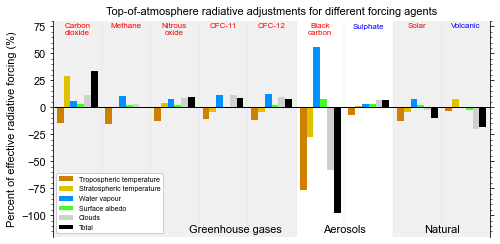

In [18]:
fig, ax1 = pl.subplots()

colors = ['#a03800','#d08000','#e0c000','#0090ff','#40ff20','#d0d0d0','black']
labels = ['Surface temperature','Tropospheric temperature','Stratospheric temperature','Water vapour','Surface albedo','Clouds','Total']
for ie, expt in enumerate(['3xCH4', '3xN2O', '8xCFC11', '9xCFC12', '10xBC', '5xSO4', 'Solar', 'Volcanic']):
    ax1.bar(0.15+ie+1, 100*(adjustments_df.loc['ta_trop']/(adjustments_df.loc['ERF'] - adjustments_df.loc['tas'])).mean()[expt], 0.14, color=colors[1], zorder=3)
    ax1.bar(0.29+ie+1, 100*(adjustments_df.loc['ta_strat']/(adjustments_df.loc['ERF'] - adjustments_df.loc['tas'])).mean()[expt], 0.14, color=colors[2], zorder=3)
    ax1.bar(0.43+ie+1, 100*(adjustments_df.loc['hus']/(adjustments_df.loc['ERF'] - adjustments_df.loc['tas'])).mean()[expt], 0.14, color=colors[3], zorder=3)
    ax1.bar(0.57+ie+1, 100*(adjustments_df.loc['alb']/(adjustments_df.loc['ERF'] - adjustments_df.loc['tas'])).mean()[expt], 0.14, color=colors[4], zorder=3)
    ax1.bar(0.71+ie+1, 100*(adjustments_df.loc['cloud']/(adjustments_df.loc['ERF'] - adjustments_df.loc['tas'])).mean()[expt], 0.14, color=colors[5], zorder=3)
    ax1.bar(0.85+ie+1, 100*(
        (adjustments_df.loc['ta_trop']/(adjustments_df.loc['ERF'] - adjustments_df.loc['tas'])).mean()[expt] +
        (adjustments_df.loc['ta_strat']/(adjustments_df.loc['ERF'] - adjustments_df.loc['tas'])).mean()[expt] +
        (adjustments_df.loc['hus']/(adjustments_df.loc['ERF'] - adjustments_df.loc['tas'])).mean()[expt] +
        (adjustments_df.loc['alb']/(adjustments_df.loc['ERF'] - adjustments_df.loc['tas'])).mean()[expt] +
        (adjustments_df.loc['cloud']/(adjustments_df.loc['ERF'] - adjustments_df.loc['tas'])).mean()[expt]
    ), 0.14, color=colors[6], zorder=3)
    if expt in ['Volcanic', '5xSO4']:
        textcolor='blue'
    else:
        textcolor='red'
    ax1.text(0.5+ie+1, 78, expt_names[expt], ha='center', va='top', fontsize=8, color=textcolor)
ie=0
expt='2xCO2'
ax1.bar(0.15+ie, 100*(adjustments_df.loc['ta_trop']/(adjustments_df.loc['ERF'] - adjustments_df.loc['tas'])).mean()[expt], 0.14, color=colors[1], label=labels[1], zorder=3)
ax1.bar(0.29+ie, 100*(adjustments_df.loc['ta_strat']/(adjustments_df.loc['ERF'] - adjustments_df.loc['tas'])).mean()[expt], 0.14, color=colors[2], label=labels[2], zorder=3)
ax1.bar(0.43+ie, 100*(adjustments_df.loc['hus']/(adjustments_df.loc['ERF'] - adjustments_df.loc['tas'])).mean()[expt], 0.14, color=colors[3], label=labels[3], zorder=3)
ax1.bar(0.57+ie, 100*(adjustments_df.loc['alb']/(adjustments_df.loc['ERF'] - adjustments_df.loc['tas'])).mean()[expt], 0.14, color=colors[4], label=labels[4], zorder=3)
ax1.bar(0.71+ie, 100*(adjustments_df.loc['cloud']/(adjustments_df.loc['ERF'] - adjustments_df.loc['tas'])).mean()[expt], 0.14, color=colors[5], label=labels[5], zorder=3)
ax1.bar(0.85+ie, 100*(
        (adjustments_df.loc['ta_trop']/(adjustments_df.loc['ERF'] - adjustments_df.loc['tas'])).mean()[expt] +
        (adjustments_df.loc['ta_strat']/(adjustments_df.loc['ERF'] - adjustments_df.loc['tas'])).mean()[expt] +
        (adjustments_df.loc['hus']/(adjustments_df.loc['ERF'] - adjustments_df.loc['tas'])).mean()[expt] +
        (adjustments_df.loc['alb']/(adjustments_df.loc['ERF'] - adjustments_df.loc['tas'])).mean()[expt] +
        (adjustments_df.loc['cloud']/(adjustments_df.loc['ERF'] - adjustments_df.loc['tas'])).mean()[expt]
    ), 0.14, color=colors[6], zorder=3, label='Total')
ax1.text(0.5+ie, 78, expt_names[expt], ha='center', va='top', fontsize=8, color='red')

ax1.text(2.8, -118, 'Greenhouse gases', size=11, va='bottom', ha='left')
ax1.text(6, -118, 'Aerosols', size=11, va='bottom', ha='center')
ax1.text(8, -118, 'Natural', size=11, va='bottom', ha='center')

ax1.set_ylabel('Percent of effective radiative forcing (%)')

ax1.axhline(0, color='k', lw=1, zorder=4)

for x in range(1,9):
    ax1.axvline(x,lw=0.2,color='#d0d0d0')

mn,mx = ax1.get_ylim()
backfill = [0,5,5,7,7,9]
fillind  = [1,1,0,0,1,1]
ax1.fill_between(backfill, -120, 100, where=fillind, color='#f0f0f0', zorder=0.6)
ax1.legend(loc='lower left', framealpha=1, fontsize=7, ncol=1)#, bbox_to_anchor=[0.46,1])
ax1.set_ylim(-120,80)
ax1.set_xlim(0,9)
#ax1.grid(axis='y', zorder=-11, lw=0.5)

ax1.set_title('Top-of-atmosphere radiative adjustments for different forcing agents', fontsize=11)

fig.tight_layout()

pl.savefig('../figures/fig7.4.png', dpi=300)
pl.savefig('../figures/fig7.4.pdf')